# Creación de un clasificador de imágenes mediante la API secuencial de Keras

### Usando Keras para cargar el conjunto de datos

Empecemos cargando el conjunto de datos MNIST de moda. Keras tiene una serie de funciones para cargar conjuntos de datos populares en `tf.keras.datasets`. El conjunto de datos ya está dividido entre un conjunto de entrenamiento (60.000 imágenes) y un conjunto de prueba (10.000 imágenes), pero puede ser útil dividir el conjunto de entrenamiento aún más para tener un conjunto de validación. Utilizaremos 55.000 imágenes para el entrenamiento y 5.000 para la validación.

In [3]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [4]:
# El conjunto de entrenamiento contiene 60.000 imágenes en escala de grises de 28x28 píxeles cada una:

X_train.shape

(55000, 28, 28)

In [5]:
# La intensidad de cada píxel se representa como un byte (de 0 a 255):

X_train.dtype

dtype('uint8')

In [7]:
'''
Por simplicidad, escalemos las intensidades de los píxeles al rango 0-1
y convirtámoslas en flotantes, dividiendo por 255.0:
'''

X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

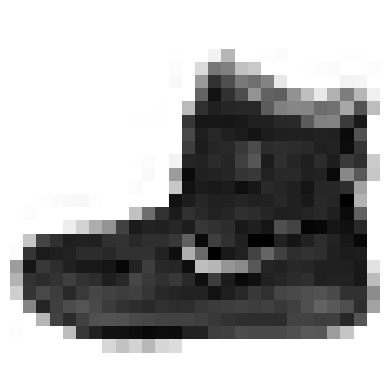

In [9]:
'''
Grafiquemos una imagen de entrenamiento usando la función imshow()
de Matplotlib, con un mapa de color 'binario':
'''
import matplotlib.pyplot as plt

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [10]:
# Las etiquetas son los ID de clase (representados como uint8), de 0 a 9:

y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

In [11]:
# Estos son los nombres de las clases correspondientes:
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [12]:
# Verifiquemos la etiqueta la primera imagen del conjunto de entrenamiento:

class_names[y_train[0]]

'Ankle boot'

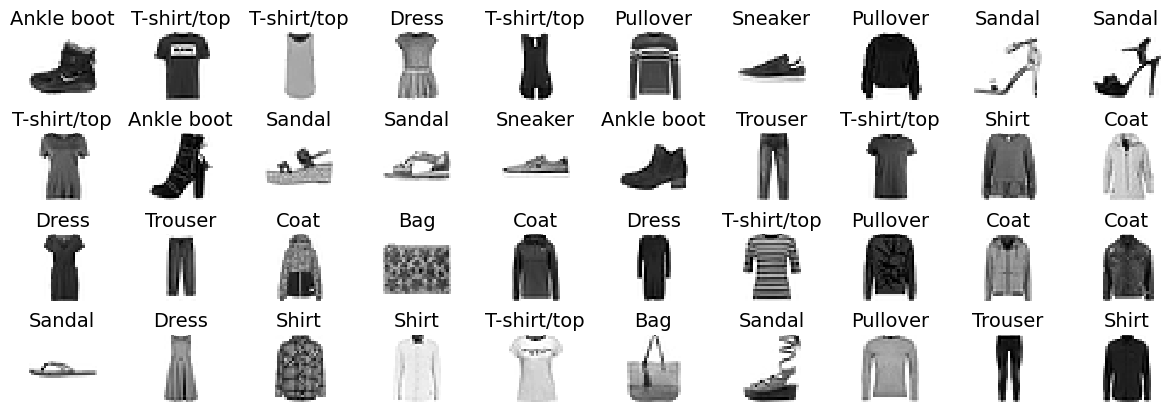

In [14]:
# Veamos una muestra de las imágenes del conjunto de entrenamiento:

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Creemos el modelo mediante la API secuencial de Keras

Ahora vamos a construir la red neuronal. Aquí tenemos una RNA de clasificación con dos capas ocultas:

In [15]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

Revisemos este código línea por línea:


*   En primer lugar, establece la semilla aleatoria de TensorFlow para que los resultados sean reproducibles: los pesos aleatorios de las capas ocultas y la capa de salida serán los mismos cada vez que ejecutes el código. También se puede utilizar la función `tf.keras.utils.set_random_seed()`, que establece convenientemente las semillas aleatorias para TensorFlow, Python(`random.seed()`), y NumPy (`np.random.seed()`).
*   La siguiente línea crea un modelo `Sequential()`. Este es el tipo más simple de modelo Keras para redes neuronales que sólo están compuestas por una única pila de capas conectadas secuencialmente. Esto se llama la API secuencial.
*   A continuación, construimos la primera capa (`InputLayer()`) y la añadimos al modelo. Especificamos la forma de la entrada, que no incluye el tamaño del lote (*batch size*), sólo la forma de las instancias. Keras necesita conocer la forma de las entradas para poder determinar la forma de la matriz de pesos de conexión de la primera capa oculta.
*   A continuación, añadimos una capa `Flatten()`. Su función es convertir cada imagen de entrada en una matriz 1D: por ejemplo, si recibe un lote de forma [32, 28, 28], le dará la forma [32, 784]. En otras palabras, si recibe datos de entrada X, calcula `X.reshape(-1, 784)`. Esta capa no tiene ningún parámetro; sólo está ahí para hacer un simple preprocesamiento.
*   A continuación añadimos una capa oculta `Dense()` con 300 neuronas. Utilizará la función de activación ReLU. Cada capa densa gestiona su propia matriz de pesos, que contiene todos los pesos de conexión entre las neuronas y sus entradas. También gestiona un vector de términos de sesgo (uno por neurona). Cuando recibe algunos datos de entrada, calcula la activación ($f(w^TX+b)$).
*   A continuación, añadimos una segunda capa oculta `Dense()` con 100 neuronas, utilizando también la función de activación ReLU.
*   Por último, añadimos una capa de salida `Dense()` con 10 neuronas (una por clase), utilizando la función de activación Softmax porque las clases son excluyentes.

#### Nota
La función ReLU es continua, pero desafortunadamente no es diferenciable en z = 0 (la pendiente cambia bruscamente, lo que puede hacer que el descenso por gradiente rebote), y su derivada es 0 para z < 0. En la práctica, sin embargo, funciona muy bien y tiene la ventaja de ser rápida de calcular, por lo que se ha convertido en la **predeterminada**. Es importante destacar que el hecho de que no tenga un valor de salida máximo ayuda a reducir algunos problemas durante el descenso de gradiente.

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


El método `summary()` del modelo muestra todas las capas del modelo, incluyendo el nombre de cada capa (que se genera automáticamente a menos que se establezca al crear la capa), su forma de salida (`None` significa que el tamaño del lote (*batch size*) puede ser cualquiera) y su número de parámetros. El resumen termina con el número total de parámetros, incluyendo los parámetros entrenables y no entrenables. Aquí sólo tenemos parámetros entrenables (veremos algunos parámetros no entrenables más adelante)

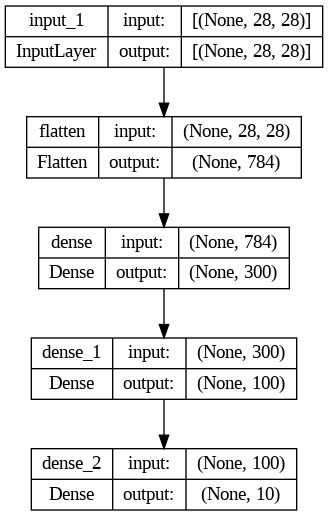

In [17]:
# Otra forma de mostrar la arquitectura del modelo
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

Puede obtener fácilmente la lista de capas de un modelo utilizando el atributo `layers`, o utilizar el método `get_layer()` para acceder a una capa por su nombre:

In [19]:
model.layers

In [20]:
hidden1 = model.layers[1]
hidden1.name

'dense'

Se puede acceder a todos los parámetros de una capa utilizando sus métodos `get_weights()` y `set_weights()`. Para una capa `Dense`, esto incluye tanto los pesos de conexión como los términos de sesgo:

In [21]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.00235178, -0.04096692, -0.010743  , ...,  0.06491643,
         0.06846347, -0.05056792],
       [-0.00661197, -0.0602446 , -0.01302794, ..., -0.0508846 ,
        -0.04711264,  0.02165034],
       [-0.03508209,  0.01924855,  0.06921284, ..., -0.00374702,
        -0.06678671,  0.02386449],
       ...,
       [-0.04130341,  0.05174679, -0.04263742, ..., -0.05906611,
        -0.00661846,  0.00785971],
       [-0.01591586, -0.05094287,  0.05235656, ...,  0.00479401,
         0.07214083,  0.01859342],
       [ 0.06167713, -0.06189182, -0.00546233, ...,  0.00776099,
         0.07392824, -0.03744819]], dtype=float32)

In [23]:
weights.shape

(784, 300)

In [22]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [29]:
biases.shape

(300,)

Observe que la capa `Dense` inicializó los pesos de conexión aleatoriamente (lo cual es necesario para romper la simetría, como se discutió anteriormente), y los sesgos se inicializaron a ceros, lo cual está bien. Si desea utilizar un método de inicialización diferente, puede establecer `kernel_initializer` (*kernel* es otro nombre para la matriz de pesos de conexión) o `bias_initializer` al crear la capa. Hablaremos de los inicializadores más adelante.
La lista completa de *initializers* está en https://keras.io/api/layers/initializers/

## Compilación del modelo
Después de crear un modelo, debe llamar a su método `compile()` para especificar la función de pérdida y el optimizador a utilizar. Opcionalmente, puede especificar una lista de métricas adicionales para calcular durante el entrenamiento y la evaluación:

In [30]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Veamos una explicación del código:


*   Utilizamos la pérdida "`sparse_categorical_crossentropy`" porque tenemos etiquetas dispersas (es decir, para cada instancia, sólo hay un índice de clase objetivo, de 0 a 9 en este caso), y las clases son exclusivas. Si en cambio tuviéramos una probabilidad objetivo por clase para cada instancia (como *one-hot vectors*, por ejemplo, [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] para representar la clase 3), entonces tendríamos que utilizar la pérdida "`categorical_crossentropy`". Si estuviéramos haciendo una clasificación binaria, entonces utilizaríamos la función de activación "`sigmoide`" en la capa de salida en lugar de la función de activación "`softmax`", y utilizaríamos la pérdida "`binary_crossentropy`".
*   En cuanto al optimizador, "`sgd`" significa que entrenaremos el modelo utilizando el descenso de gradiente estocástico. En otras palabras, Keras ejecutará el algoritmo de *backpropagation* descrito anteriormente. Discutiremos optimizadores más eficientes luego.
*   Por último, dado que se trata de un clasificador, es útil medir su exactitud (*accuracy*) durante el entrenamiento y la evaluación, por lo que establecemos `metrics=["accuracy"]`.



## Entrenamiento y evaluación del modelo
Ahora el modelo está listo para ser entrenado. Para ello sólo tenemos que llamar a su método `fit()`:

In [31]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 12s 6ms/step - loss: 0.7252 - accuracy: 0.7636 - val_loss: 0.5062 - val_accuracy: 0.8276
Epoch 2/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4932 - accuracy: 0.8291 - val_loss: 0.4659 - val_accuracy: 0.8352
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4460 - accuracy: 0.8438 - val_loss: 0.4264 - val_accuracy: 0.8500
Epoch 4/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4204 - accuracy: 0.8528 - val_loss: 0.3998 - val_accuracy: 0.8596
Epoch 5/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3988 - accuracy: 0.8602 - val_loss: 0.3922 - val_accuracy: 0.8620
Epoch 6/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3815 - accuracy: 0.8647 - val_loss: 0.3972 - val_accuracy: 0.8632
Epoch 7/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3692 - accuracy: 0.8690 - val_loss: 0.3768 - val_accuracy